# Практическая работа 6. Нейронные сети

**Задача: "Определение подлинности подписи на основе изображений с использованием
нейронной сети"**

Описание задачи: Решить задачу бинарной классификации, используя нейронные сети для
определения подлинности подписи на изображениях. Задача состоит в разработке модели,
которая способна отличать подлинные подписи от поддельных на основе предоставленных
изображений.

In [7]:
# !kaggle datasets download -d divyanshrai/handwritten-signatures
# !unzip handwritten-signatures.zip

В итоге имеем 4 папки.

Проверим что папки с одинаковым названием, но с разным регистром имеют одинаковые файлы

In [8]:
import os

def list_files(startpath):
    file_list = []
    for root, dirs, files in os.walk(startpath):
        for f in files:
            file_list.append(os.path.join(root, f).lower())  # Приводим путь к нижнему регистру
    return file_list

def compare_directories(dir1, dir2):
    files1 = list_files(dir1)
    files2 = list_files(dir2)

    files1_set = set(files1)
    files2_set = set(files2)

    if files1_set == files2_set:
        print(f"Directories {dir1} and {dir2} have the same files.")
    else:
        print(f"Directories {dir1} and {dir2} have different files.")
        print(f"Files only in {dir1}: {files1_set - files2_set}")
        print(f"Files only in {dir2}: {files2_set - files1_set}")

# Проверка содержимого папок
compare_directories('sample_signature', 'sample_Signature')
compare_directories('dataset_signature_final', 'Dataset_Signature_Final')


Directories sample_signature and sample_Signature have the same files.
Directories dataset_signature_final and Dataset_Signature_Final have the same files.


**Проверим видит ли TensorFlow GPU**

In [9]:
import tensorflow as tf

# Проверка доступности GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


Посчитаем количество изображений в обеих папках(150+150)

Это необходимо чтобы задать количество батчей

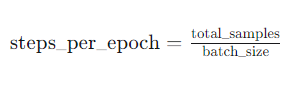

In [10]:
def count_images(startpath):
    image_extensions = {'.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff', '.tif'}
    image_count = 0

    for root, dirs, files in os.walk(startpath):
        for file in files:
            if os.path.splitext(file)[1].lower() in image_extensions:
                image_count += 1

    return image_count

# Подсчет количества изображений в папках
print(count_images('sample_signature/sample_Signature/forged') + count_images('sample_signature/sample_Signature/genuine'))

300


Идеально иметь много шагов в 1 эпохе.

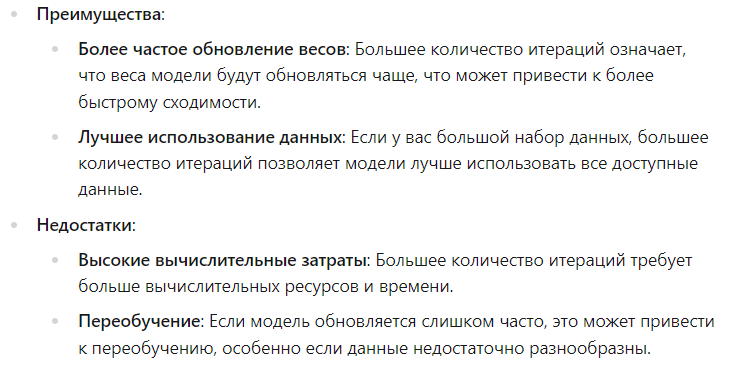

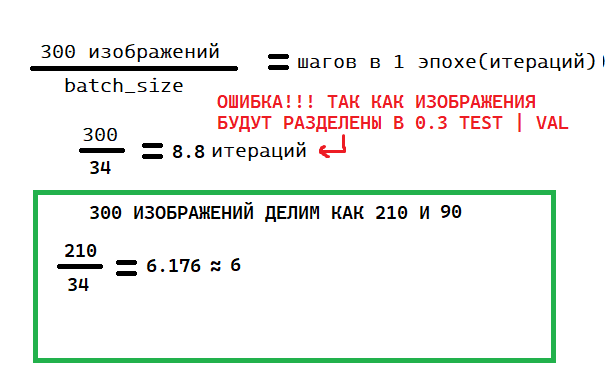

Проверить с validation проверку на validation_steps и data

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import os

# Параметры
img_width, img_height = 150, 50
# 34 изображений в 1 батче
batch_size = 34 # Если batch_size меньше 32, то обнуляет train и не проверяет val???
epochs = 30

# Генераторы данных
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)

# Обучающая выборка из sample_signature
train_generator = train_datagen.flow_from_directory(
    'sample_signature/sample_Signature',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='training')

# Валидационная выборка из sample_signature
validation_generator = train_datagen.flow_from_directory(
    'sample_signature/sample_Signature',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation')

# Создание модели
model = Sequential([
    Input(shape=(img_width, img_height, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Компиляция модели
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Обучение модели
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs)

Found 210 images belonging to 2 classes.
Found 90 images belonging to 2 classes.
Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 450ms/step - accuracy: 0.5239 - loss: 1.9940 - val_accuracy: 0.4706 - val_loss: 1.1985
Epoch 2/30
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5294 - loss: 1.0999

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - accuracy: 0.5294 - loss: 1.0999 - val_accuracy: 0.3636 - val_loss: 0.9609
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 213ms/step - accuracy: 0.5716 - loss: 0.7092 - val_accuracy: 0.2647 - val_loss: 1.2838
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.7647 - loss: 0.6338 - val_accuracy: 0.3182 - val_loss: 1.1305
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.6818 - loss: 0.6433 - val_accuracy: 0.2353 - val_loss: 0.8395
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6765 - loss: 0.6348 - val_accuracy: 0.3182 - val_loss: 0.8368
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.7505 - loss: 0.5205 - val_accuracy: 0.2500 - val_loss: 1.5150
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6471 - loss: 0.5974 - val_accuracy: 0.1818 - val_loss: 1.0472
Epoch 9/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.8037 - loss: 0.4769 - val_accuracy: 0.2353 - val_loss: 1.3433
Epoch 10/

ImageDataGenerator с параметром flow_from_directory, автоматически создает метки классов на основе структуры папок.

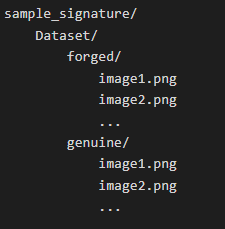

ImageDataGenerator будет считать, что все изображения в папке forged принадлежат классу "forged", а все изображения в папке genuine принадлежат классу "genuine"

ImageDataGenerator shaffle-ит данные, помещает их в сэмплы и затем использует батчи для эпох

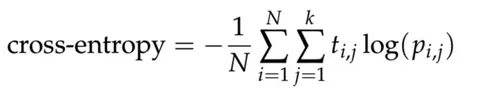

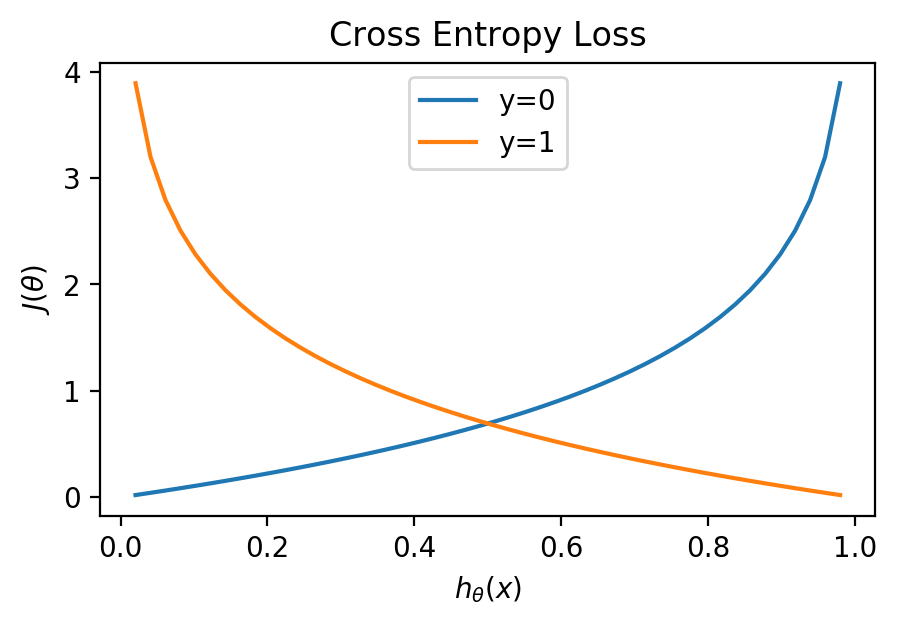

Simple

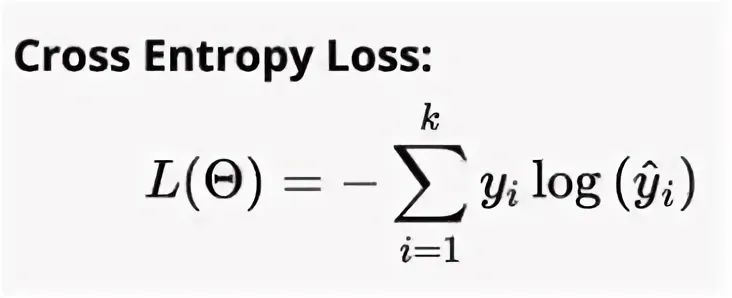

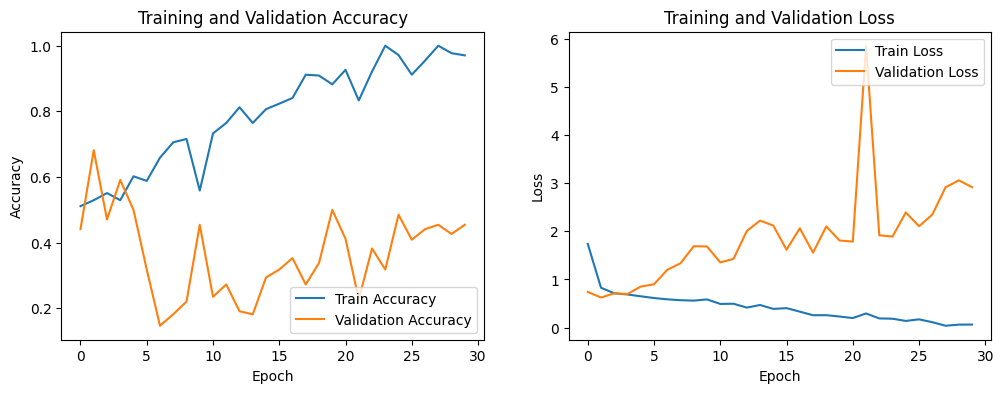

In [14]:
import matplotlib.pyplot as plt

# Визуализация графиков обучения
plt.figure(figsize=(12, 4))

# График точности
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# График потерь
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

Я специально переобучил алгоритм, чтобы посмотреть на тесте точность

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


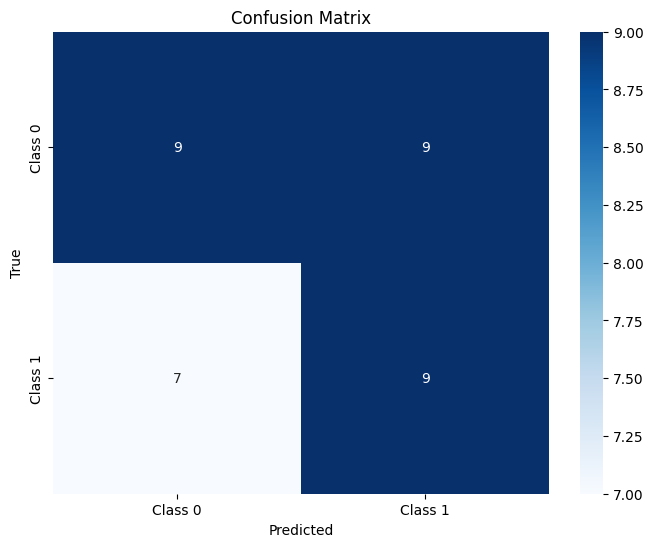

In [15]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Получение предсказаний модели на валидационном наборе данных
validation_data, validation_labels = next(validation_generator)
predictions = model.predict(validation_data)
predicted_labels = (predictions > 0.5).astype(int)  # Пороговое значение для бинарной классификации

# Построение матрицы ошибок
cm = confusion_matrix(validation_labels, predicted_labels)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [16]:
# Оценка модели на dataset_signature_final
test_datagen = ImageDataGenerator(rescale=1./255)

# Тестовая выборка из dataset_signature_final
test_generator = test_datagen.flow_from_directory(
    'dataset_signature_final/Dataset/dataset1',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

# Оценка модели
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test accuracy on dataset1: {test_acc}')

Found 120 images belonging to 2 classes.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9706 - loss: 0.0863
Test accuracy on dataset1: 0.970588207244873


In [17]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'dataset_signature_final/Dataset/dataset2',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test accuracy on dataset2: {test_acc}')

Found 120 images belonging to 2 classes.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step - accuracy: 0.8407 - loss: 0.4273
Test accuracy on dataset2: 0.843137264251709


In [18]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'dataset_signature_final/Dataset/dataset3',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test accuracy on dataset3: {test_acc}')

Found 300 images belonging to 2 classes.
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 528ms/step - accuracy: 0.7763 - loss: 1.1150
Test accuracy on dataset3: 0.8161764740943909


In [19]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'dataset_signature_final/Dataset/dataset4',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test accuracy on dataset4: {test_acc}')

Found 180 images belonging to 2 classes.
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.6251 - loss: 2.7082
Test accuracy on dataset4: 0.6117647290229797


C 1 по 4 датасет сложность нарастает. Подпись становится менее различимой от оригинальной

# GAN

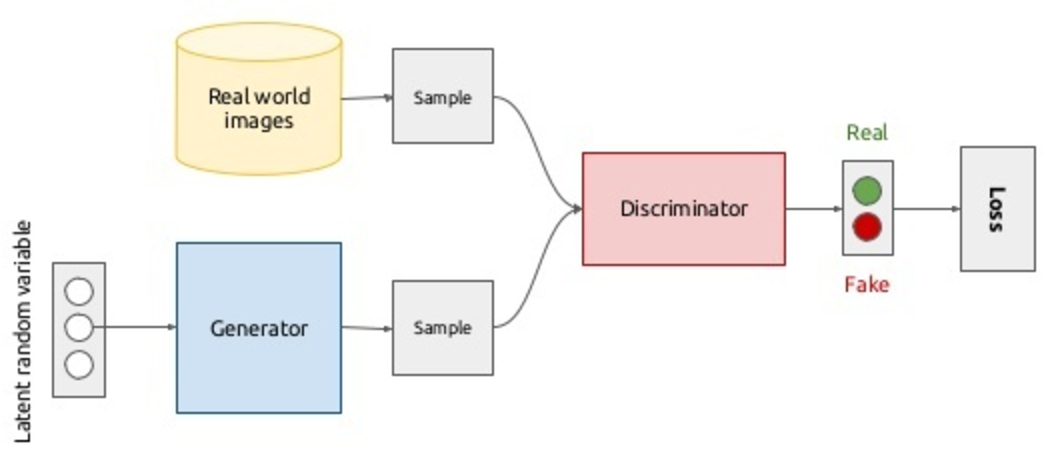

У меня получился не GAN, а CNN, c двойным loss и бесполезными последовательными слоями для обучения дескриминатора. Я бы назвал такую сеть как CNN с двойным loss и двойным обучением

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os

# Параметры
img_width, img_height = 150, 50
batch_size = 34
epochs = 34 # выше не выдерживает колаб

# Генераторы данных
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)

# Обучающая выборка из sample_signature
train_generator = train_datagen.flow_from_directory(
    'sample_signature/sample_Signature',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='training')

# Валидационная выборка из sample_signature
validation_generator = train_datagen.flow_from_directory(
    'sample_signature/sample_Signature',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation')

# Создание дискриминатора
def build_discriminator():
    model = Sequential()
    model.add(Input(shape=(img_width, img_height, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Компиляция дискриминатора
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Обучение дискриминатора
for epoch in range(epochs):
    for _ in range(train_generator.samples // batch_size):
        # Получение пары изображений
        real_images, real_labels = next(train_generator)
        fake_images, fake_labels = next(train_generator)

        # Убедимся, что размеры совпадают
        if real_images.shape[0] != fake_images.shape[0]:
            min_size = min(real_images.shape[0], fake_images.shape[0])
            real_images = real_images[:min_size]
            real_labels = real_labels[:min_size]
            fake_images = fake_images[:min_size]
            fake_labels = fake_labels[:min_size]

        # Иногда отправляем одно и то же изображение для обоих классов
        if np.random.rand() < 0.5:
            fake_images = real_images

        # Обучение дискриминатора
        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    print(f"{epoch + 1}/{epochs} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}]")

# Сохранение модели
discriminator.save('discriminator_model.h5')

Found 210 images belonging to 2 classes.
Found 90 images belonging to 2 classes.
1/34 [D loss: 1.8895237445831299 | D accuracy: 54.00228500366211]
2/34 [D loss: 1.3124170303344727 | D accuracy: 54.04627323150635]
3/34 [D loss: 1.1035666465759277 | D accuracy: 56.907618045806885]
4/34 [D loss: 0.9793392419815063 | D accuracy: 59.19004678726196]
5/34 [D loss: 0.9102317690849304 | D accuracy: 60.9819769859314]
6/34 [D loss: 0.8599517345428467 | D accuracy: 62.58667707443237]
7/34 [D loss: 0.8066749572753906 | D accuracy: 64.7180438041687]
8/34 [D loss: 0.7701864838600159 | D accuracy: 67.02946424484253]
9/34 [D loss: 0.7570583820343018 | D accuracy: 67.47843623161316]
10/34 [D loss: 0.7392705678939819 | D accuracy: 68.46398711204529]
11/34 [D loss: 0.7151741981506348 | D accuracy: 69.99766826629639]
12/34 [D loss: 0.7111194133758545 | D accuracy: 69.79254484176636]
13/34 [D loss: 0.697504997253418 | D accuracy: 70.83873748779297]
14/34 [D loss: 0.6822131872177124 | D accuracy: 71.76405787

34/34 [D loss: 0.5690556764602661 | D accuracy: 78.5330057144165]


Плохо обучилась модель, выше 0.8 можно достичь

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
[[0.44529057]
 [0.83368886]]


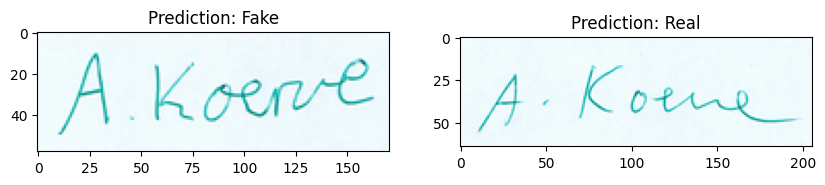

In [6]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

# Загрузка моделей
discriminator = load_model('discriminator_model.h5')

# Функция для загрузки и предсказания изображения
def load_and_predict(img_paths):
    images = []
    for img_path in img_paths:
        img = image.load_img(img_path, target_size=(img_width, img_height))
        img_array = image.img_to_array(img)
        images.append(img_array)
    images = np.array(images)
    images = images / 255.0
    predictions = discriminator.predict(images)
    return predictions

# Тестирование на новых изображениях
img_path1 = 'sample_signature/sample_Signature/forged/NFI-00101014.png'
img_path2 = 'sample_signature/sample_Signature/genuine/NFI-01403014.png'

img_paths = [img_path1, img_path2]
predictions = load_and_predict(img_paths)

print(predictions)

# Вывод изображений и результатов
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i, img_path in enumerate(img_paths):
    axes[i].imshow(image.load_img(img_path))
    axes[i].set_title(f'Prediction: {"Real" if predictions[i] > 0.5 else "Fake"}')
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


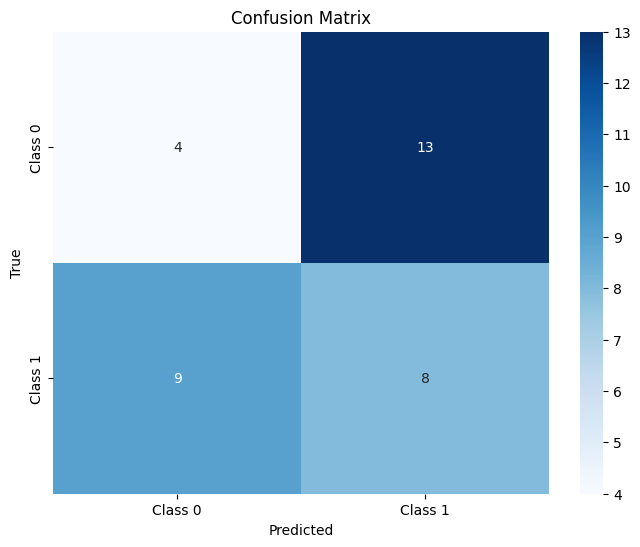

In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Получение предсказаний модели на валидационном наборе данных
validation_data, validation_labels = next(validation_generator)
predictions = discriminator.predict(validation_data)
predicted_labels = (predictions > 0.5).astype(int)  # Пороговое значение для бинарной классификации

# Построение матрицы ошибок
cm = confusion_matrix(validation_labels, predicted_labels)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [8]:
# Оценка модели на dataset_signature_final
test_datagen = ImageDataGenerator(rescale=1./255)

# Тестовая выборка из dataset_signature_final
test_generator = test_datagen.flow_from_directory(
    'dataset_signature_final/Dataset/dataset1',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

# Оценка модели
test_loss, test_acc = discriminator.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test accuracy on dataset1: {test_acc}')

Found 120 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.9669 - loss: 0.3672
Test accuracy on dataset1: 0.970588207244873


In [9]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'dataset_signature_final/Dataset/dataset2',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')
test_loss, test_acc = discriminator.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test accuracy on dataset2: {test_acc}')

Found 120 images belonging to 2 classes.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 427ms/step - accuracy: 0.7598 - loss: 0.5597
Test accuracy on dataset2: 0.7843137383460999


In [11]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'dataset_signature_final/Dataset/dataset3',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')
test_loss, test_acc = discriminator.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test accuracy on dataset3: {test_acc}')

Found 300 images belonging to 2 classes.
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 463ms/step - accuracy: 0.8023 - loss: 0.4401
Test accuracy on dataset3: 0.783088207244873


In [12]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'dataset_signature_final/Dataset/dataset4',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')
test_loss, test_acc = discriminator.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test accuracy on dataset4: {test_acc}')

Found 180 images belonging to 2 classes.
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.6391 - loss: 0.5961
Test accuracy on dataset4: 0.6294117569923401


**Результат - обычная CNN лучше**